# Lightweight Fine-Tuning Project

TODO: In this cell, describe your choices for each of the following

* PEFT technique: LoRA, or Low-Rank Adaptation, is implemented in this project as it is a technique used to fine-tune large language models efficiently. Instead of adjusting all the model parameters, LoRA introduces low-rank matrices into the model architecture, allowing for more efficient training and less memory usage. This makes it particularly useful for tasks where you want to adapt a pre-trained model to specific requirements without the computational overhead of full retraining.
* Model: GPT2ForSequenceClassification is used for this task as it is a model from the Hugging Face Transformers library that adapts the GPT-2 architecture for the specific task of sequence classification. This means it's designed to classify input text into predefined categories, making it suitable for tasks like sentiment analysis, topic classification, or any scenario where you need to assign a label to a sequence of text.
* Evaluation approach: The evaluate() method in the Hugging Face Transformers library's Trainer class is used to evaluate the model on the validation and test dataset as this method computes various metrics to assess the model's performance. 
* Fine-tuning dataset: Emotion is a dataset of English Twitter messages with six basic emotions: anger, fear, joy, love, sadness, and surprise which is suitable for the desired task.

## Loading and Evaluating a Foundation Model

TODO: In the cells below, load your chosen pre-trained Hugging Face model and evaluate its performance prior to fine-tuning. This step includes loading an appropriate tokenizer and dataset.

In [28]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding 
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
import pandas as pd
from peft import LoraConfig, TaskType, get_peft_model, AutoPeftModelForSequenceClassification

In [3]:
#Load the dataset
#https://huggingface.co/datasets/dair-ai/emotion
dataset = load_dataset("dair-ai/emotion", "split")
#Emotions dictionary with all the 6 emotions with their id's
emotions = {0 : 'sadness', 1 : 'joy', 2 : 'love', 3 : 'anger',
             4: 'fear', 5 : 'surprise'}
#Adding the emotions column to the dataset mapped with the id's
dataset = dataset.map(lambda x: {'emotions': emotions[x['label']]})
id2label = emotions
label2id = {v : k for k,v in emotions.items()}

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [4]:
def print_statistics(dataset, subset):
    df = dataset[subset].to_pandas()
    print('No. of samples in {} set: {}'.format(subset, len(df)))
    print('')
    display(df.head())
    df.emotions.value_counts().plot.bar()

No. of samples in train set: 16000



,text,label,emotions
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


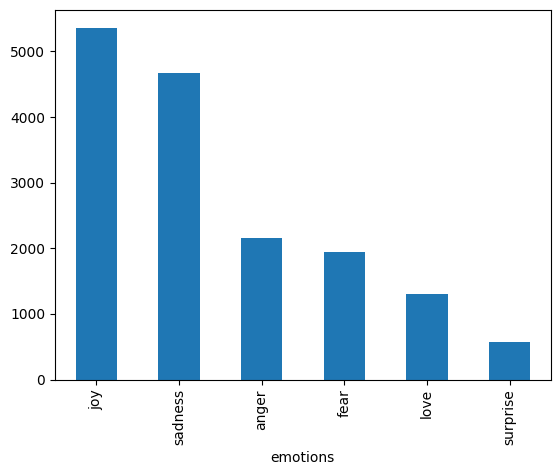

In [5]:
print_statistics(dataset, 'train')

No. of samples in validation set: 2000



,text,label,emotions
0,im feeling quite sad and sorry for myself but ...,0,sadness
1,i feel like i am still looking at a blank canv...,0,sadness
2,i feel like a faithful servant,2,love
3,i am just feeling cranky and blue,3,anger
4,i can have for a treat or if i am feeling festive,1,joy


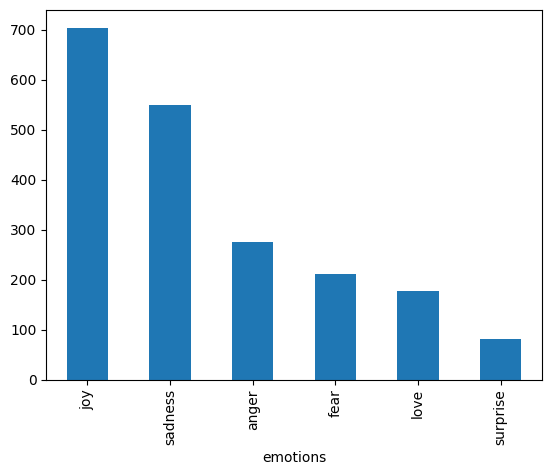

In [6]:
print_statistics(dataset, 'validation')

No. of samples in test set: 2000



,text,label,emotions
0,im feeling rather rotten so im not very ambiti...,0,sadness
1,im updating my blog because i feel shitty,0,sadness
2,i never make her separate from me because i do...,0,sadness
3,i left with my bouquet of red and yellow tulip...,1,joy
4,i was feeling a little vain when i did this one,0,sadness


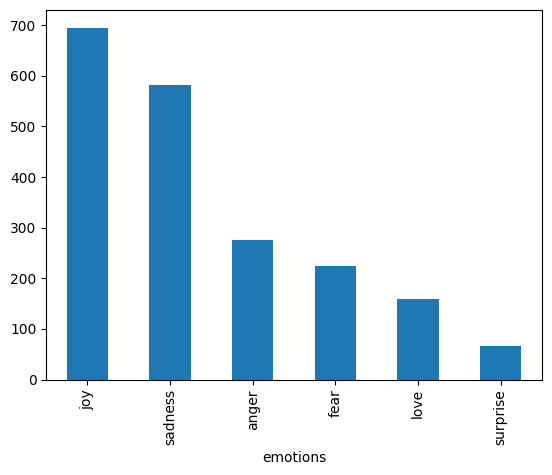

In [7]:
print_statistics(dataset, 'test')

# Define the tokenizer and tokenize the data



In [8]:
tokenizer = AutoTokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

def tokenize(data):
    tokenized_data = tokenizer(data['text'], padding=True, truncation=True)
    return tokenized_data

tokenized_data = dataset.map(tokenize, batched=True)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

# Load the model

In [9]:
model = AutoModelForSequenceClassification.from_pretrained("gpt2", 
                                                           num_labels=len(emotions),
                                                           id2label=id2label,
                                                           label2id=label2id)

#Set the model's pad token id same as the tokenizer's pad token id
model.config.pad_token_id = tokenizer.pad_token_id

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
#Freeze the base model's parameters
for param in model.base_model.parameters():
    param.requires_grad = False

print(model)

GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=6, bias=False)
)


In [17]:
#Function to compute the performance metrics of the model
def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    labels = eval_pred.label_ids
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted', zero_division=1)
    return {'accuracy': accuracy_score(labels, predictions), 'f1 score' : f1, 'precision' : precision, 'recall' : recall}

#Training arguments to pass to the model
training_args = TrainingArguments(
            output_dir='./model_result',
            learning_rate=2e-5,
            per_device_train_batch_size=64,
            per_device_eval_batch_size=64,
            evaluation_strategy="epoch",
            save_strategy="epoch",
            num_train_epochs=5,
            weight_decay=0.01,
            load_best_model_at_end=True,
)

trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_data['train'],
        eval_dataset=tokenized_data['validation'],
        tokenizer=tokenizer,
        data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
        compute_metrics=compute_metrics,
)

# Evaluate the model

In [18]:
trainer.evaluate()

{'eval_loss': 6.469465255737305,
 'eval_accuracy': 0.2755,
 'eval_f1 score': 0.1197918475868201,
 'eval_precision': 0.7340265531062125,
 'eval_recall': 0.2755,
 'eval_runtime': 7.5434,
 'eval_samples_per_second': 265.133,
 'eval_steps_per_second': 4.242}

## Performing Parameter-Efficient Fine-Tuning

TODO: In the cells below, create a PEFT model from your loaded model, run a training loop, and save the PEFT model weights.

In [31]:
#Parameters for LoRA Configuraton
peft_config = LoraConfig(
            task_type=TaskType.SEQ_CLS,
            target_modules=['c_attn', 'c_proj'],
            r=8,
            lora_alpha=32,
            lora_dropout=0.1,
            bias='none')


model = AutoModelForSequenceClassification.from_pretrained("gpt2", 
                                                           num_labels=len(emotions),
                                                           id2label=id2label,
                                                           label2id=label2id)
model.config.pad_token_id = tokenizer.pad_token_id

#Get the model with LoRA Configuraton
peft_model = get_peft_model(model, peft_config)
peft_model.print_trainable_parameters()

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/peft/tuners/lora.py:475: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


trainable params: 820,224 || all params: 125,260,032 || trainable%: 0.6548170129798466


In [32]:
training_args = TrainingArguments(
            output_dir='./peft_model_result',
            learning_rate=2e-5,
            per_device_train_batch_size=64,
            per_device_eval_batch_size=64,
            evaluation_strategy="epoch",
            save_strategy="epoch",
            num_train_epochs=5,
            weight_decay=0.01,
            load_best_model_at_end=True,
)

trainer = Trainer(
        model=peft_model,
        args=training_args,
        train_dataset=tokenized_data['train'],
        eval_dataset=tokenized_data['validation'],
        tokenizer=tokenizer,
        data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
        compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1 score,Precision,Recall
1,No log,1.584055,0.364000,0.279869,0.285535,0.364000
2,1.708000,1.534375,0.405000,0.316469,0.450543,0.405000
3,1.708000,1.340232,0.529000,0.428480,0.598552,0.529000
4,1.346700,1.109612,0.589500,0.507492,0.659775,0.589500
5,1.346700,1.078975,0.598000,0.522348,0.657438,0.598000


Checkpoint destination directory ./peft_model_result/checkpoint-250 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./peft_model_result/checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./peft_model_result/checkpoint-750 already exists and is non-empty.Saving will proceed but saved results may be invalid.


TrainOutput(global_step=1250, training_loss=1.4485774169921874, metrics={'train_runtime': 1089.2007, 'train_samples_per_second': 73.448, 'train_steps_per_second': 1.148, 'total_flos': 3536825338626048.0, 'train_loss': 1.4485774169921874, 'epoch': 5.0})

In [21]:
trainer.evaluate()

{'eval_loss': 1.1840230226516724,
 'eval_accuracy': 0.5665,
 'eval_f1 score': 0.4920278728991705,
 'eval_precision': 0.6612527175958445,
 'eval_recall': 0.5665,
 'eval_runtime': 9.2091,
 'eval_samples_per_second': 217.176,
 'eval_steps_per_second': 3.475,
 'epoch': 5.0}

In [33]:
peft_model.save_pretrained('model/peft_model')

## Performing Inference with a PEFT Model

TODO: In the cells below, load the saved PEFT model weights and evaluate the performance of the trained PEFT model. Be sure to compare the results to the results from prior to fine-tuning.

In [34]:
inference_model = AutoPeftModelForSequenceClassification.from_pretrained('model/peft_model',
                                                   num_labels=len(emotions))

inference_model.config.pad_token_id = tokenizer.pad_token_id

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
training_args = TrainingArguments(
            output_dir='./inference_model_result',
            learning_rate=2e-5,
            per_device_train_batch_size=64,
            per_device_eval_batch_size=64,
            evaluation_strategy="epoch",
            save_strategy="epoch",
            num_train_epochs=5,
            weight_decay=0.01,
            load_best_model_at_end=True,
)

trainer = Trainer(
        model=inference_model,
        args=training_args,
        train_dataset=tokenized_data['train'],
        eval_dataset=tokenized_data['test'],
        tokenizer=tokenizer,
        data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
        compute_metrics=compute_metrics,
)

trainer.evaluate()

{'eval_loss': 1.0703593492507935,
 'eval_accuracy': 0.6125,
 'eval_f1 score': 0.5402759461146447,
 'eval_precision': 0.6571398596658051,
 'eval_recall': 0.6125,
 'eval_runtime': 8.3468,
 'eval_samples_per_second': 239.614,
 'eval_steps_per_second': 3.834}

## Conclusion

As we can see from the results, using PEFT (Parameter Efficient Fine-Tuning), we only modify a small number of parameters of the model, in this case only 0.6548170129798466 % of parameters are trained, which saves a lot of computation power and resources.
Also, we can see, we get significant improvements in various metrics like accuracy, recall and f1 score by training the PEFT model for just a few epochs in comparasion to the foundation model.